## Import modules

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
import os

## Select the spot intensity analysis file to open
Should be a spot analysis.csv file containing the intensity per frame of each particle, derived from the Spot Intensity Analysis plugin in Fiji

In [96]:
path = input("Enter the path to the spot analysis.csv from Fiji: ")
df = pd.read_csv(path)

# Drop the first two columns (columns containing X and Y coordinates of each particle)
df = df.iloc[:, 2:]

Enter the path to the spot analysis.csv from Fiji: /Users/steinar/Documents/Data/4 - cell vs. endosomal membrane in fusion/3 - IAV content mixing with PMVs/content mixing kinetics/Spot analysis of PMV+IAV3_MMStack_Default.csv


## _Optional: Remove Calcein background signal before buffer exchange._ 
Converts the intensity of frame 1 to background_stabilised to the intensity set by background_stabilised

In [97]:
# set the frame where Calcein background fluorescence was completely removed
background_stabilised = 13

for index, row in df.iterrows():
    for i in range(0, background_stabilised):
        df.iat[index, i] = row[background_stabilised+1]

#  Event analysis
Set parameters for the event analysis.

The analysis will search for a sharp increase in particle intensity, above the event_threshold, and mark the time point as a potential event.

In [107]:
# set the time (s) where fusion was triggered
fusion_trigger_time = 10

# set the minimum threshold for a potential fusion event to be recorded (1000 - 2000 is a good starting point)
event_threshold = 1000

# set the number of frames to be averaged before/after the potential even. Small clusters run the risk of detecting spikes.
cluster_size = 2

# if set to "yes", the analysis will detect sharp decreases in particle intensity instead
leakage_events = "no"

events = {}
# Iterate over each particle's intensity
for i in range(len(df)):
    particle = df.iloc[i]
    frames = particle[:].values

    # Iterate over the frames for the current particle by x frames at a time
    for j in range(0, len(frames) - cluster_size): # remove the last frames to avoid error when reaching end of iteration
        before_change = mean(frames[j : j + cluster_size])
        after_change = mean(frames[j + cluster_size : j + cluster_size*2])
        difference = after_change - before_change
        
        changes = []
        for k in range(0, cluster_size*2):
            try:
                change = abs(frames[j+k] - frames[j+k+1])
                changes.append(change)
            except:
                continue
        
        if leakage_events == "yes":
            # Check if the difference is smaller than the negative threshold (sharp decrease)
            if difference < -2000:
                # Initialize a list for the particle if it doesn't exist in the dictionary
                if i not in events:
                    events[i] = []

                max_value = changes.index(max(changes))

                # Store the frame in the dictionary
                if not (j+max_value) in events[i]:
                    events[i].append(j+max_value)
        else:
            # Check if the difference is larger than the threshold (sharp increase)
            if difference > event_threshold:
                # Initialize a list for the particle if it doesn't exist in the dictionary
                if i not in events:
                    events[i] = []

                max_value = changes.index(max(changes))

                # Store the frame in the dictionary
                if not (j+max_value) in events[i]:
                    events[i].append(j+max_value)

## Print list of all event times and manually remove recurring events
If many events occur at the same time point, it may be a focusing event

In [111]:
# fill in the list with the time points you want to remove events from
remove_events = [12, 15,17, 35, 40, 42, 76, 81,16, 82, 132,19, 22, 23, 25]

events = {key: [value for value in values if value not in remove_events] for key, values in events.items()}
events = {key: values for key, values in events.items() if len(values) > 0}

print("All time points where a potential event was detected:")
for frames in sorted(list(events.values())):
    print(frames)

All time points where a potential event was detected:
[13, 84, 122]
[14]
[14]
[14, 18, 44, 49, 51, 52, 103, 263, 292, 294]
[18]
[18]
[18]
[18, 265, 290]
[20, 152]
[21, 125, 240, 254, 265, 292, 294]
[24, 28, 51]
[24, 46, 48, 53, 84, 91, 135, 152, 163, 176, 184, 198, 203, 244, 294]
[28]
[29, 46, 50, 51, 55, 91, 152, 159, 197]
[36]
[36]
[36]
[36]
[36]
[36]
[36, 291]
[46, 48, 137, 152, 176]
[46, 50, 51, 152, 176, 198]
[48, 51]
[50, 51]
[50, 51, 91, 138, 152, 198]
[50, 51, 135, 152, 158, 176, 184, 198, 243]
[51]
[51]
[51]
[51]
[51, 152, 176, 184, 198]
[51, 198]
[52]
[60]
[80, 94]
[103, 122, 254, 263, 292]
[122, 254, 263, 291]
[123, 291]
[125]
[125, 254, 263, 292]
[127]
[127, 135, 138, 152, 158, 177, 179, 184, 198]
[130]
[130, 131]
[131]
[131, 290]
[147]
[208]
[208]
[208]
[213]
[223]
[230]
[231]
[236]
[243]
[254]
[263, 292]
[290]
[290]
[292]
[292]


## Plots the intensity profile of each particle with a detected event
Dashed line = time where event was detected

Green line = time where buffer exchange was triggered

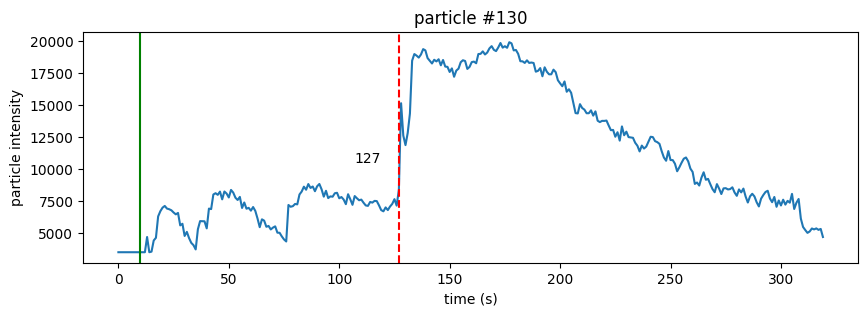

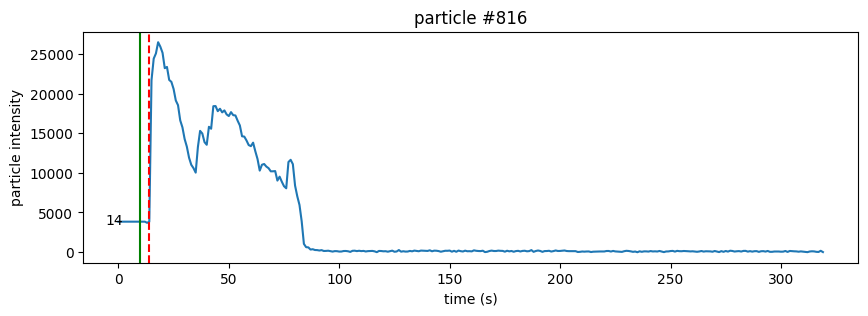

In [114]:
for i in events.keys():
    partricle_nr = i
    data = df.iloc[partricle_nr]
    x_values = [float(index) for index in data.index]
    y_values = data.values
    plt.figure(figsize=(10, 3)) # 10, 3
    plt.plot(x_values, y_values, marker='', linestyle='-')
    plt.axvline(x=fusion_trigger_time, color='green', linestyle='-')
    # Set labels and title
    plt.xlabel('time (s)')
    plt.ylabel('particle intensity')
    plt.title(f"particle #{i}")
    # Add vertical lines for each x-axis position in frames_dict
    for x in events[partricle_nr]:
        plt.axvline(x=x, color='red', linestyle='--')
        plt.text(x=x-20,y=mean(y_values),s=x)

    plt.show()

## _Optional: Fill in a list of particle #'s to either be exclusively kept, or removed from dataset_

In [113]:
particles_of_interest = [130,816]
action = "retain"
# "retain" to retain only these particle in the dataset
# "remove" to remove these particle specifically from the dataset


if action == "retain":
    events = {key: value for key, value in events.items() if key in particles_of_interest}
    print("Only particles specified retained in the dataset.")
if action == "remove":
    try:
        for i in particles_of_interest:
            del events[i]
        print("Particles removed successfully.")
    except Exception as e:
        print(f"Error: particle #{e} not found, could not execute.")

Only particles specified retained in the dataset.


## Extract all waiting times and subtract time before fusion trigger

Also removes events occurring before fusion was triggered.

In [115]:
# Flatten the dictionary values into a single list
values = [value for values_list in events.values() for value in values_list]
# Create a DataFrame with a single column named "waiting_times"
waiting_times = pd.DataFrame({'waiting_times': values}).sort_values(by = 'waiting_times')

# subtract frames before fusion was triggered and remove events occurring before fusion trigger
waiting_times = waiting_times.sub(fusion_trigger_time)
waiting_times = waiting_times.drop(waiting_times[waiting_times['waiting_times'] < 0].index)

# Display the resulting DataFrame
print(waiting_times)

   waiting_times
1              4
0            117


## save the waiting time list as a .csv file

In [116]:
# Specify the filename you would like
output_filename = "PMV content mixing 3"

# saves the .csv file in the same folder as the input spot intensity file
directory, filename = os.path.split(path)
if not directory.endswith(os.path.sep):
    directory += os.path.sep

try:
    waiting_times.to_csv(directory + output_filename + ".csv", index=False, header=True, mode='x')
except:
    print("file name already exists")